In [49]:
import os
import glob

import pandas as pd
from torch_geometric.data import Data

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

import numpy as np
import networkx as nx
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv
from torch.nn import LogSoftmax, BatchNorm1d, Dropout, Module
import torch.optim as optim

import matplotlib.pyplot as plt
from collections import Counter

In [50]:
from functools import partial


def read_data(root_dir, encoding, max_length=100):
    documents = []
    class_names = []

    categories = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

    for category in categories:
        class_path = os.path.join(root_dir, category)
        for i, file_path in enumerate(glob.glob(os.path.join(class_path, '*'))):
            if i > max_length:
                break
            if os.path.isfile(file_path):
                with open(file_path, 'r', encoding=encoding, errors='ignore') as file:
                    content = file.read()
                    documents.append(content)
                    class_names.append(category)
    return documents, class_names, categories

read_ohsumed_data = partial(read_data, encoding='utf-8')
read_20ng_data = partial(read_data, encoding='ascii')

In [51]:
root_dir = "datasets/20ng"
# root_dir = "datasets/ohsumed"
NUM_CLASSES = 20
texts, labels, categories = read_20ng_data(root_dir, max_length=80)

labels2idx = {category: idx for idx, category in enumerate(categories)}
all_words = " ".join(texts).split(' ')

print(texts[0])

Archive-name: atheism/resources
Alt-atheism-archive-name: resources
Last-modified: 11 December 1992
Version: 1.0
                              Atheist Resources
                      Addresses of Atheist Organizations
Darwin fish bumper stickers and assorted other atheist paraphernalia are
available from the Freedom From Religion Foundation in the US.
Write to:  FFRF, P.O. Box 750, Madison, WI 53701.
Telephone: (608) 256-8900
Evolution Designs sell the "Darwin fish".  It's a fish symbol, like the ones
Christians stick on their cars, but with feet and the word "Darwin" written
inside.  The deluxe moulded 3D plastic fish is $4.95 postpaid in the US.
Write to:  Evolution Designs, 7119 Laurel Canyon #4, North Hollywood,
People in the San Francisco Bay area can get Darwin Fish from Lynn Gold --
try mailing <figmo@netcom.com>.  For net people who go to Lynn directly, the
price is $4.95 per fish.
AAP publish various atheist books -- critiques of the Bible, lists of
Biblical contradictions, an

In [52]:
%%time
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(texts)

cosine_sim = cosine_similarity(tfidf_matrix)

similarity_threshold = 0.9

edge_index = []
for i in tqdm(range(len(texts))):
    for j in range(len(texts)):
        if i != j and cosine_sim[i, j] > similarity_threshold:
            edge_index.append([i, j])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

tfidf_features = tfidf_matrix.toarray()

100%|██████████| 1620/1620 [00:00<00:00, 2684.03it/s]


CPU times: user 1.23 s, sys: 121 ms, total: 1.35 s
Wall time: 1.35 s


In [53]:
%%time
# 使用PCA对特征进行降维，减小计算量
n_components = 1000
print(f"降维前{tfidf_features.shape[1]}->降维后{n_components}")
pca = PCA(n_components=n_components)
tfidf_features = pca.fit_transform(tfidf_features)

降维前34951->降维后1000
CPU times: user 3min 53s, sys: 2min 47s, total: 6min 41s
Wall time: 19 s


In [54]:
# 转换为PyTorch张量
x = torch.FloatTensor(tfidf_features)
y = torch.LongTensor([labels2idx[label] for label in labels])

# 创建PyTorch Geometric图数据
data = Data(x=x, edge_index=edge_index, y=y)

num_nodes = data.num_nodes
train_val_ratio = 0.8
cut_point = int(num_nodes * train_val_ratio)  # 例如，80%的节点用于训练

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)

indices = np.random.permutation(num_nodes)
train_mask[indices[:cut_point]] = True
val_mask[indices[cut_point:]] = True

data.train_mask = train_mask
data.val_mask = val_mask

In [58]:
class GAT(Module):
    name = 'GAT'
    def __init__(self, input_dim, hidden_dim, out_dim, dropout_rate, num_heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim * num_heads, out_dim, heads=1, concat=False)
        self.dropout = Dropout(dropout_rate)
        self.bn1 = BatchNorm1d(hidden_dim * num_heads)
        self.logsoftmax = LogSoftmax(dim=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        
        x = x.view(-1, self.conv1.heads * self.conv1.out_channels)
        x = self.bn1(x)
        
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.logsoftmax(x)
        return x
    

class GCN(Module):
    name = "GCN"
    def __init__(self, input_dim, hidden_dim, out_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.dropout = Dropout(dropout_rate)
        self.logsoftmax = LogSoftmax(dim=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.logsoftmax(x)
        return x

In [59]:
%%time
NUM_EPOCHS = 100
LR = 0.005

# 创建模型实例
model = GCN(input_dim=data.x.shape[1], hidden_dim=64, out_dim=NUM_CLASSES, dropout_rate=0.6)
# model = GAT(input_dim=data.x.shape[1], hidden_dim=64, out_dim=NUM_CLASSES, dropout_rate=0.6)
optimizer = optim.Adam(model.parameters(), lr=LR)


losses, val_accuracies = [], []
# 训练循环
p_bar = tqdm(range(NUM_EPOCHS))
for epoch in p_bar:
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        correct = pred[data.val_mask] == data.y[data.val_mask]
        val_acc = int(correct.sum()) / int(data.val_mask.sum())
        
    losses.append(loss.item())
    val_accuracies.append(val_acc)
    p_bar.set_postfix(epoch=epoch, loss=f"{loss.item():.4f}", val_acc=f"{val_acc:.4f}")
    
# 保存模型
torch.save(model.state_dict(), f'{model.name}_model.pt')


100%|██████████| 100/100 [00:00<00:00, 104.30it/s, epoch=99, loss=0.1222, val_acc=0.6080]

CPU times: user 15.2 s, sys: 31.2 ms, total: 15.2 s
Wall time: 965 ms


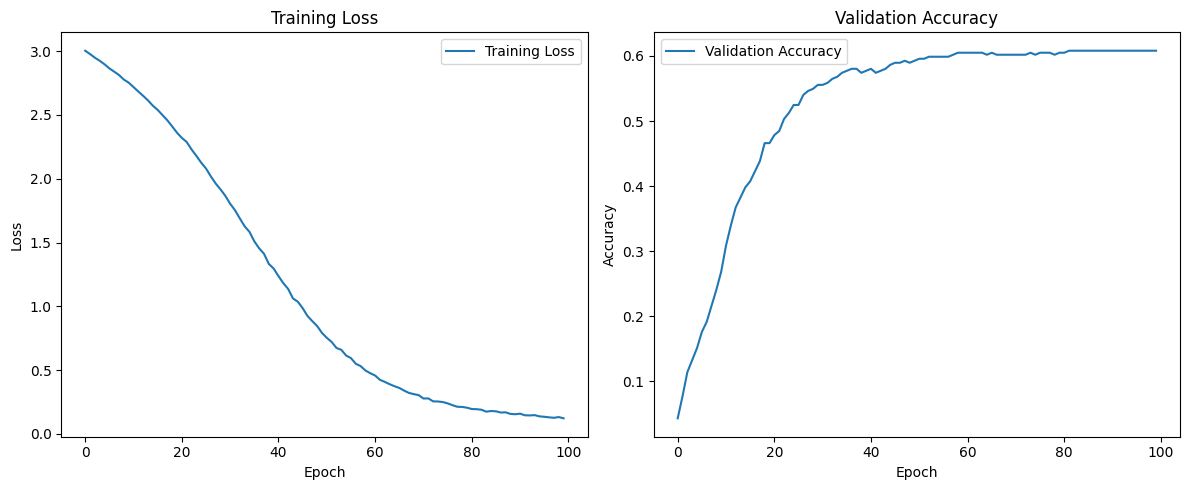

In [60]:
plt.figure(figsize=(12, 5))

# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制验证准确率
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()